# Seq2Seq & Attention


---

- Before starting this practice, please set the Colab environment to use GPU.

- Connect → Change runtime type → Select T4 GPU → Save

0. Prepare the practice environment

1. RNN (Character-level prediction) <br>

2. Seq2Seq model</br>

3. Attention mechanism and visualization

## 0. Prepare the practice environment

In [ ]:
# Install the required libraries in Colab or your local environment.
!pip install torch matplotlib

In [ ]:
# Import the libraries required for the practice.
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import unicodedata
import re
import random
import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
# Set up GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

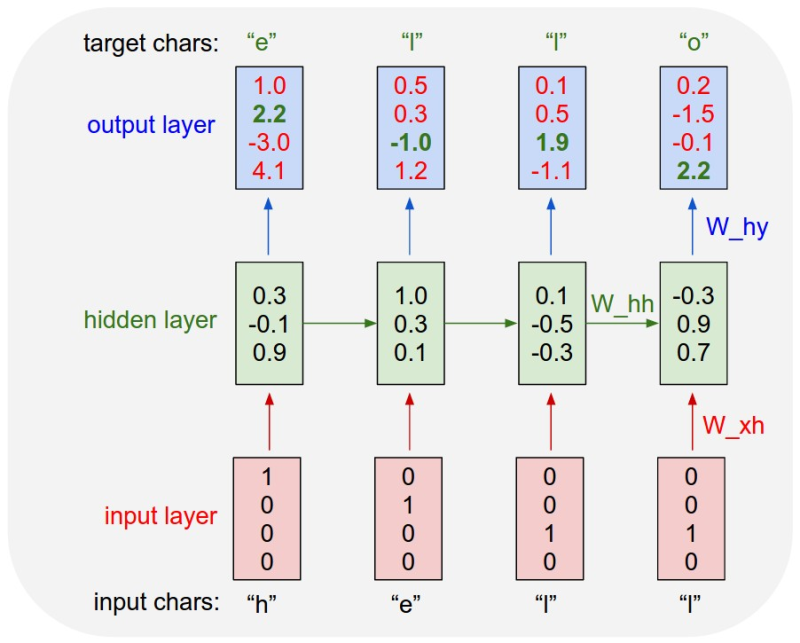

## 1. Visualizing RNN Memory (Character-level Prediction)

In [ ]:
# 1. Data Preparation
# Word list for model training
corpus = ['apple', 'banana', 'google', 'orange', 'grape', 'peach']

# Data preprocessing
unique_chars = sorted(list(set(''.join(corpus)))) # Find all unique characters in the corpus
char_to_int = {char: i for i, char in enumerate(unique_chars)} # Convert characters to integers
int_to_char = {i: char for i, char in enumerate(unique_chars)} # Convert integers back to characters
n_chars = len(unique_chars)

# One-hot vector generation
def to_one_hot(char):
    tensor = torch.zeros(1, n_chars)
    tensor[0][char_to_int[char]] = 1
    return tensor

In [ ]:
# 2. Define the RNN model
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        # RNN layer: takes the input (character) and updates the internal memory (hidden state)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        # Fully Connected (fc) layer: takes the RNN output and predicts the next character
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        # Reshape the output tensor for prediction
        out = self.fc(out.view(out.size(0), -1))
        return out, hidden

    # Function to initialize the RNN’s hidden state
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [ ]:
# 3. Model Training
# Set model hyperparameters
hidden_size = 10  # Amount of information the model can remember (larger values allow learning more complex patterns)
learning_rate = 0.005  # Determines how much the model updates its parameters each step
num_epochs = 300  # Total number of training iterations

model = CharRNN(n_chars, hidden_size, n_chars).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("===== Start Training RNN Model =====")
for epoch in range(num_epochs):
    total_loss = 0
    # Train each word in the corpus sequentially
    for word in corpus:
        # Initialize the RNN’s hidden state at the start of each word
        # (to prevent the previous word’s memory from affecting the next one)
        hidden = model.init_hidden().to(device)

        # Iterate through each character in the word and train the model
        # to predict the next character
        # e.g., 'apple' -> ('a'->'p'), ('p'->'p'), ('p'->'l'), ('l'->'e')
        for i in range(len(word) - 1):
            input_char = to_one_hot(word[i]).to(device)
            target_char_idx = torch.tensor([char_to_int[word[i+1]]], dtype=torch.long).to(device)

            optimizer.zero_grad()
            output, hidden = model(input_char.unsqueeze(0), hidden)

            # Important!! Detach the hidden state before moving to the next character
            # to prevent gradients from propagating through the entire sequence
            hidden = hidden.detach()

            loss = criterion(output, target_char_idx)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss/len(corpus):.4f}')

print("===== Training Complete! =====\n")

In [ ]:
# 4. Visualization and Testing
def generate_text(model, start_char, predict_len=10):
    print(f"===== Prediction Results (Start Character: '{start_char}') =====")
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        hidden = model.init_hidden().to(device)
        current_char = start_char
        result_str = start_char

        # Continuously predict the next character for the specified length
        for _ in range(predict_len):
            input_tensor = to_one_hot(current_char).to(device)
            output, hidden = model(input_tensor.unsqueeze(0), hidden)

            # Select the character with the highest probability as the next character
            topv, topi = output.topk(1)
            predicted_char_idx = topi[0].item()
            predicted_char = int_to_char[predicted_char_idx]

            print(f"Next prediction after '{current_char}' -> '{predicted_char}'")

            result_str += predicted_char
            current_char = predicted_char  # Use the predicted character as the next input

        print(f"\nFinal generated text: '{result_str}'")

In [ ]:
# --- Execution ---
# Generate text starting with 'a'
# Since 'apple' exists in the corpus, it is expected to generate a word similar to 'apple'
generate_text(model, start_char='a', predict_len=8)

print("-" * 30)

# Generate text starting with 'b'
# Since 'banana' exists in the corpus, it is expected to generate a word similar to 'banana'
generate_text(model, start_char='b', predict_len=5)

## 2. Seq2Seq

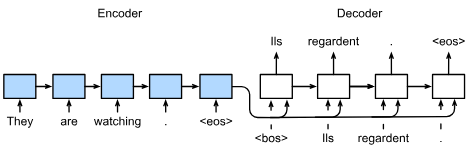

In [ ]:
# coding: utf-8
import torch
import torch.nn as nn
import re
import random
import unicodedata

# Set up GPU usage (needed when running on Colab or similar environments)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# 1. Data Preparation and Preprocessing Class
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 20  # Limit sentence length to shorten training time

# Prefix patterns of English sentences (used for filtering training data)
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

input_data = 'data/eng-fra.txt'

# Vocabulary class
class Lang:
    def __init__(self, name):
        self.name = name  # Language name (e.g., 'eng')
        self.word2index = {}  # word -> index (e.g., {'hello': 2})
        self.word2count = {}  # word -> count (e.g., {'hello': 10})
        self.index2word = {0: "SOS", 1: "EOS"}  # index -> word
        self.n_words = 2  # total number of words in the vocabulary

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Data preprocessing functions
# Convert Unicode string to ASCII
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalize_string(s):
    # Convert Unicode to ASCII and make lowercase
    s = unicode_to_ascii(s.lower().strip())
    # Add a space before punctuation
    s = re.sub(r"([.!?])", r" \1", s)  # e.g., 'he is.' -> 'he is .'
    # Replace non-alphabetic characters with spaces (remove digits, symbols)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# Load and filter data
def read_langs_from_file(lang1, lang2, file_path, reverse=False):
    print("Reading lines...")
    # Read file
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.read().strip().split('\n')

    # Split each line and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # Reverse language order (Fra -> Eng)
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

# Check if a sentence pair meets our desired conditions
def filter_pair(p):
    # Check sentence length and English prefix pattern
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)  # To switch direction (Eng->Fra), change p[1] -> p[0]

# Apply filtering to multiple sentence pairs
def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

# Prepare and process data
def prepare_data(lang1, lang2, file_path, reverse=False):
    # Read sentence pairs and Lang objects from file
    input_lang, output_lang, pairs = read_langs_from_file(lang1, lang2, file_path, reverse)
    print(f"Read {len(pairs)} sentence pairs")

    # Keep only pairs that meet the filter conditions
    pairs = filter_pairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")

    # Build vocabularies from filtered sentences
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs

# Load data from file
input_lang, output_lang, pairs = prepare_data('fra', 'eng', input_data, True)
print("\n===== Sample Data =====")
print(random.choice(pairs))

# Convert sentence to tensor
def tensor_from_sentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

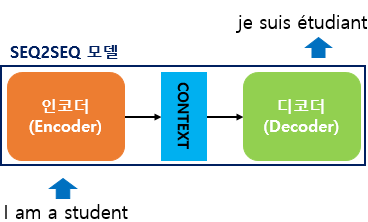

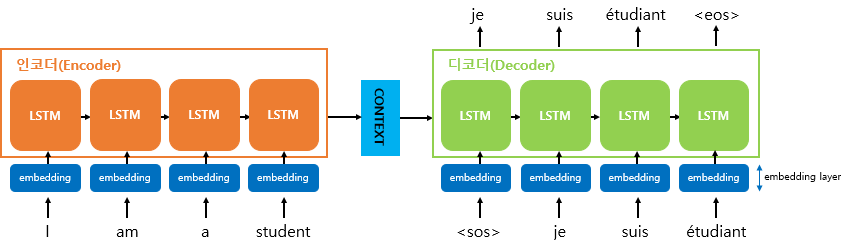

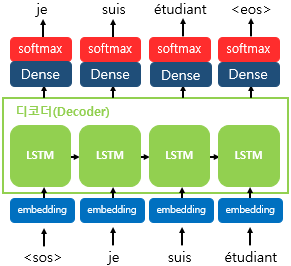

In [ ]:
# 2. Define Seq2Seq Model (Encoder and Decoder)
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # Embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        # GRU layer (RNN)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # Embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        # GRU layer (RNN)
        self.gru = nn.GRU(hidden_size, hidden_size)
        # Dense layer
        self.out = nn.Linear(hidden_size, output_size)
        # Activation function
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = torch.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [ ]:
# 3. Model Training
def train_s2s(input_tensor, target_tensor, encoder, decoder, enc_optimizer, dec_optimizer, criterion):
    encoder_hidden = torch.zeros(1, 1, encoder.hidden_size, device=device)
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    loss = 0

    # Encoder phase
    for ei in range(input_tensor.size(0)):
        _, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

    # Decoder phase
    decoder_hidden = encoder_hidden
    decoder_input = torch.tensor([[SOS_token]], device=device)

    for di in range(target_tensor.size(0)):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        loss += criterion(decoder_output, target_tensor[di])
        # Teacher Forcing
        decoder_input = target_tensor[di]
        if decoder_input.item() == EOS_token:
            break

    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    return loss.item() / target_tensor.size(0)


hidden_size = 128
encoder_wk3 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_wk3 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

enc_optimizer = torch.optim.SGD(encoder_wk3.parameters(), lr=0.01)
dec_optimizer = torch.optim.SGD(decoder_wk3.parameters(), lr=0.01)
criterion = nn.NLLLoss()

num_epochs = 10000
print("\n===== Start Training Model (approximately 2 minutes 40 seconds) =====")
for iter in range(1, num_epochs + 1):
    training_pair = random.choice(pairs)
    input_t = tensor_from_sentence(input_lang, training_pair[0])
    target_t = tensor_from_sentence(output_lang, training_pair[1])
    loss = train_s2s(input_t, target_t, encoder_wk3, decoder_wk3, enc_optimizer, dec_optimizer, criterion)
    if iter % 1000 == 0:
        print(f"Iter [{iter}/{num_epochs}], Loss: {loss:.4f}")

In [ ]:
# 4. Visualization and Testing
def evaluate_s2s(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence)
        encoder_hidden = torch.zeros(1, 1, hidden_size, device=device)

        for ei in range(input_tensor.size(0)):
            _, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

        decoder_hidden = encoder_hidden
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoded_words = []

        for _ in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()

        return ' '.join(decoded_words)

In [ ]:
# Execution
def test_translation():
    print("\n===== Translation Quality Test =====")
    for i in range(5):
        pair = random.choice(pairs)
        print(f"Input: {pair[0]}")
        print(f"Target: {pair[1]}")
        output_words = evaluate_s2s(encoder_wk3, decoder_wk3, pair[0])
        print(f"Translated Output: {output_words}")
        print("-" * 20)

test_translation()

## 3. Attention Mechanism

In [ ]:
# coding: utf-8
import torch
import torch.nn as nn
import re
import random
import unicodedata
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set up GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# 1. Data Preparation and Preprocessing Class
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 20  # Set maximum sentence length

# Prefix patterns for filtering English sentences
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Convert Unicode → ASCII
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# Read and preprocess data from file
def read_langs_from_file(lang1, lang2, file_path, reverse=False):
    print("Reading lines...")
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

# Data filtering
def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

# Integrate data loading and preprocessing
def prepare_data(lang1, lang2, file_path, reverse=False):
    input_lang, output_lang, pairs = read_langs_from_file(lang1, lang2, file_path, reverse)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filter_pairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(f"{input_lang.name}: {input_lang.n_words}")
    print(f"{output_lang.name}: {output_lang.n_words}")
    return input_lang, output_lang, pairs

# Load data from file
input_lang, output_lang, pairs = prepare_data('fra', 'eng', input_data, True)
print("\n===== Sample Data =====")
print(random.choice(pairs))

def tensor_from_sentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# Define Encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

In [ ]:
# 2. Define Attention Decoder
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        # Embedding and Dropout layers
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        # Attention weight calculation layer
        self.attn = nn.Linear(self.hidden_size * 2, MAX_LENGTH)
        # Layer to combine attention results
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Compute attention weights
        attn_weights = torch.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

        # Apply attention weights to encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # Combine embedding and attention results
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = torch.relu(output)
        output, hidden = self.gru(output, hidden)
        output = torch.log_softmax(self.out(output[0]), dim=1)

        return output, hidden, attn_weights

In [ ]:
# 3. Training the Attention Model
def train_attn(input_tensor, target_tensor, encoder, decoder, enc_optimizer, dec_optimizer, criterion):
    encoder_hidden = torch.zeros(1, 1, encoder.hidden_size, device=device)
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    loss = 0

    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
    for ei in range(input_tensor.size(0)):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_hidden = encoder_hidden
    decoder_input = torch.tensor([[SOS_token]], device=device)

    for di in range(target_tensor.size(0)):
        decoder_output, decoder_hidden, _ = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher Forcing
        if decoder_input.item() == EOS_token:
            break

    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()

    return loss.item() / target_tensor.size(0)


# Define model and optimizers
hidden_size = 128
encoder_wk4 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_wk4 = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
enc_optimizer_attn = torch.optim.SGD(encoder_wk4.parameters(), lr=0.01)
dec_optimizer_attn = torch.optim.SGD(decoder_wk4.parameters(), lr=0.01)
criterion = nn.NLLLoss()

num_epochs = 10000
print("\n===== Start Training Attention Model (approximately 4 minutes) =====")
for iter in range(1, num_epochs + 1):
    training_pair = random.choice(pairs)
    input_t = tensor_from_sentence(input_lang, training_pair[0])
    target_t = tensor_from_sentence(output_lang, training_pair[1])
    loss = train_attn(input_t, target_t, encoder_wk4, decoder_wk4, enc_optimizer_attn, dec_optimizer_attn, criterion)
    if iter % 1000 == 0:
        print(f"Iter [{iter}/{num_epochs}], Loss: {loss:.4f}")

In [ ]:
# 4. Visualization and Testing
def evaluate_and_show_attention(input_sentence, target_sentence):
    # Print input, target, and translation result
    print("-" * 30)
    print(f"Input    : {input_sentence}")
    print(f"Target   : {target_sentence}")

    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, input_sentence)
        encoder_outputs = torch.zeros(MAX_LENGTH, hidden_size, device=device)
        encoder_hidden = torch.zeros(1, 1, hidden_size, device=device)

        for ei in range(input_tensor.size(0)):
            encoder_output, encoder_hidden = encoder_wk4(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_hidden = encoder_hidden
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoded_words = []
        decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden, decoder_attention = decoder_wk4(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)

            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()

        # Print translation result
        print(f"Translation: {' '.join(decoded_words)}")

        # Visualize Attention Map
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
        cax = ax.matshow(decoder_attentions[:len(decoded_words), :len(input_sentence.split(' '))].numpy(), cmap='bone')
        fig.colorbar(cax)

        ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
        ax.set_yticklabels([''] + decoded_words)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.xlabel("Input Words")
        plt.ylabel("Output Words")
        plt.show()

In [ ]:
# Execution
def test_attention_visualization():
    print("\n===== Attention Map Visualization =====")
    print("Check which input words the translated words focus on (brighter areas indicate stronger attention).")

    # Randomly select one long and one short sentence pair from the dataset for testing
    long_sentence_pair = random.choice([p for p in pairs if len(p[0].split(' ')) > 5])
    short_sentence_pair = random.choice([p for p in pairs if len(p[0].split(' ')) < 5])

    evaluate_and_show_attention(long_sentence_pair[0], long_sentence_pair[1])
    evaluate_and_show_attention(short_sentence_pair[0], short_sentence_pair[1])


test_attention_visualization()